# Assignment 1: Acoustic Activity Recognition

In this assignment, you will build a machine learning system for acoustic activity recognition using your smartphone microphone. You will collect a custom audio dataset, extract various features, train multiple classification models, and evaluate their performance across different conditions. Each section below corresponds to a part of the assignment, with clear instructions and placeholders where you need to implement your solutions.

## Setup and Configuration

This section imports necessary libraries and mounts Google Drive for file access. We'll use libraries for audio processing (librosa), machine learning (scikit-learn), visualization (matplotlib, seaborn) and various utility functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import hashlib
import random
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.base import clone

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Error mounting Google Drive. Please run this cell again.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


## Dataset Configuration

Each student will have a unique dataset ID based on their name. This ID will be used to create a folder for storing your audio recordings. The configuration also defines the activities, environments, and other parameters for the assignment.

In [ ]:
# Create a unique dataset ID based on student name
def generate_dataset_id(name):
    """
    Generate a 5-digit random number based on the hash of the name.
    Use this as your dataset folder name.
    """
    hash_object = hashlib.md5(name.encode())
    hex_dig = hash_object.hexdigest()
    seed = int(hex_dig, 16) % (10**8)
    random.seed(seed)
    return random.randint(10000, 99999)

# Enter your name to generate your dataset ID
student_name = input("Enter your full name: ")
dataset_id = generate_dataset_id(student_name)
print(f"Your dataset folder ID is: {dataset_id}")
print(f"Please name your dataset folder: {dataset_id}")

# Configuration
ACTIVITIES = ['laugh', 'cough', 'clap', 'knock', 'alarm']
ENVIRONMENTS = ['small', 'large']
NUM_INSTANCES = 10
SAMPLE_RATE = 16000  # Standard sample rate for audio
WINDOW_SIZES = [1, 5, 20]  # in seconds - 3 required window sizes

Enter your full name: Andrew Kwolek
Your dataset folder ID is: 12481
Please name your dataset folder: 12481


Note: all of the input audio files should be resampled to 16kHz for analysis.

In [ ]:
# Sample function to resample the input audio to 16kHz
def load_audio_16k(path):
    audio, sr = librosa.load(path, SAMPLE_RATE=16000)  # Resample to 16 kHz
    return audio, sr

# A1.1: Data Collection (4 points)

n this section, we will validate your dataset to ensure it meets the requirements. You should have recorded 5 activities (laugh, cough, clap, knock, alarm), with 10 recordings each in 2 different environments (e.g., a small room and a large room).

This results in a total of 100 audio recordings (5 activities × 10 instances × 2 environments).

Each recording should be about 20 seconds long and named using the format activity_environment_instanceNumber.wav.

For example, cough_small_3.wav would represent the 4th coughing sample recorded in a small room.

## Dataset Management Functions

These functions help with listing, validating, and visualizing your audio files. The naming convention for your files should be: `activity_environment_instanceNumber.wav`

In [ ]:
def list_audio_files(base_path):
    """
    List all audio files in the dataset directory.

    Args:
        base_path: Path to the dataset directory

    Returns:
        List of audio file paths
    """
    audio_files = []

    # Find all WAV files in the dataset directory
    if os.path.exists(base_path):
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith('.wav'):
                    # Check if the file follows the naming convention
                    parts = os.path.splitext(file)[0].split('_')
                    if len(parts) == 3:
                        activity, environment, instance = parts
                        # Validate activity and environment
                        if activity in ACTIVITIES and environment in ENVIRONMENTS:
                            # Try to convert instance to int
                            try:
                                instance_num = int(instance)
                                if 0 <= instance_num < NUM_INSTANCES:
                                    audio_files.append(os.path.join(root, file))
                            except ValueError:
                                pass

    return audio_files

def validate_dataset(audio_files):
    """
    Validate that the dataset contains the required number and types of files.

    Args:
        audio_files: List of audio file paths

    Returns:
        dict: Statistics of the dataset
        bool: True if the dataset meets requirements
    """
    stats = {
        'total_files': 0,
        'files_by_activity': {activity: 0 for activity in ACTIVITIES},
        'files_by_environment': {env: 0 for env in ENVIRONMENTS},
        'activity_env_matrix': {
            f"{activity}_{env}": 0
            for activity in ACTIVITIES
            for env in ENVIRONMENTS
        },
        'valid': False
    }

    # Count files by activity and environment
    for file_path in audio_files:
        file_name = os.path.basename(file_path)
        parts = os.path.splitext(file_name)[0].split('_')

        if len(parts) == 3:
            activity, environment, _ = parts

            if activity in ACTIVITIES and environment in ENVIRONMENTS:
                stats['total_files'] += 1
                stats['files_by_activity'][activity] += 1
                stats['files_by_environment'][environment] += 1
                stats['activity_env_matrix'][f"{activity}_{environment}"] += 1

    # Check if all required files are present
    required_count = 0
    for activity in ACTIVITIES:
        for env in ENVIRONMENTS:
            key = f"{activity}_{env}"
            # Should have NUM_INSTANCES instances for each activity-environment pair
            if stats['activity_env_matrix'][key] == NUM_INSTANCES:
                required_count += 1

    # Set valid flag
    stats['valid'] = (required_count == len(ACTIVITIES) * len(ENVIRONMENTS))

    return stats

In [ ]:
def display_dataset_stats(stats):
    """
    Display statistics about the dataset.

    Args:
        stats: Dictionary of dataset statistics
    """
    print(f"Total files: {stats['total_files']}")
    print("\nFiles by activity:")
    for activity, count in stats['files_by_activity'].items():
        print(f"  {activity}: {count}")

    print("\nFiles by environment:")
    for env, count in stats['files_by_environment'].items():
        print(f"  {env}: {count}")

    print("\nActivity-Environment Matrix:")
    # Create a matrix for visualization
    matrix_data = np.zeros((len(ACTIVITIES), len(ENVIRONMENTS)))
    for i, activity in enumerate(ACTIVITIES):
        for j, env in enumerate(ENVIRONMENTS):
            matrix_data[i, j] = stats['activity_env_matrix'][f"{activity}_{env}"]

    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix_data, annot=True, fmt='g', cmap='viridis',
                xticklabels=ENVIRONMENTS, yticklabels=ACTIVITIES)
    plt.title('Number of recordings per activity and environment')
    plt.ylabel('Activity')
    plt.xlabel('Environment')
    plt.tight_layout()
    plt.show()

    if stats['valid']:
        print("\n✅ Dataset meets the requirements!")
    else:
        print("\n❌ Dataset does not meet requirements. Please check your files.")

def plot_audio_waveform(audio_path):
    """
    Plot the waveform of an audio file.

    Args:
        audio_path: Path to the audio file
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Create the plot
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {os.path.basename(audio_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # Display audio player
    display(ipd.Audio(y, rate=sr))

Now that we have the dataset management functions, let's use them to verify your dataset. The code below will list the files in your dataset folder, compute dataset statistics, and display a summary. It will also randomly select a few audio files and display their waveforms as a quick inspection of your recordings.

Checking dataset...
Total files: 100

Files by activity:
  laugh: 20
  cough: 20
  clap: 20
  knock: 20
  alarm: 20

Files by environment:
  small: 50
  large: 50

Activity-Environment Matrix:


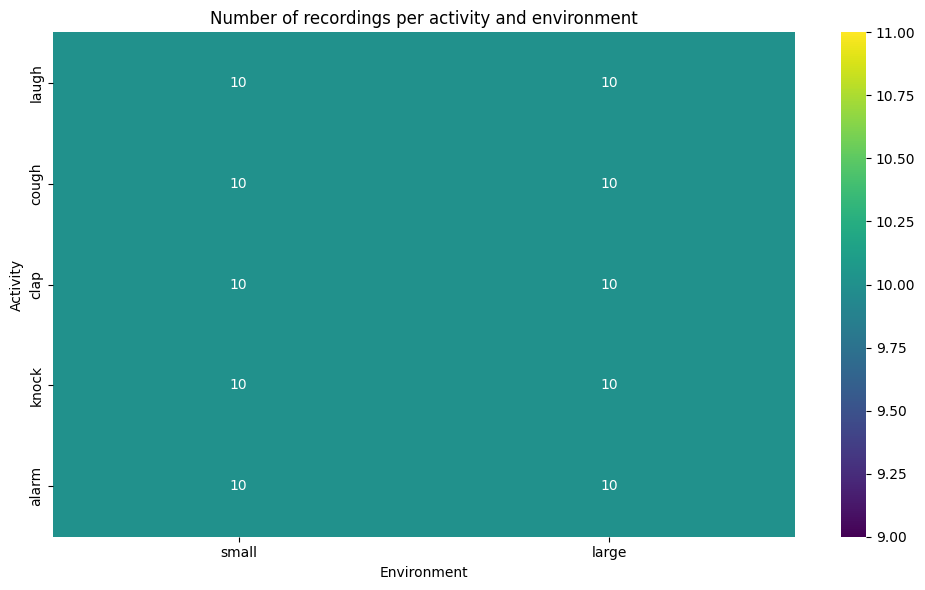


✅ Dataset meets the requirements!

Displaying a sample of audio files:

Audio file: alarm_small_1.wav


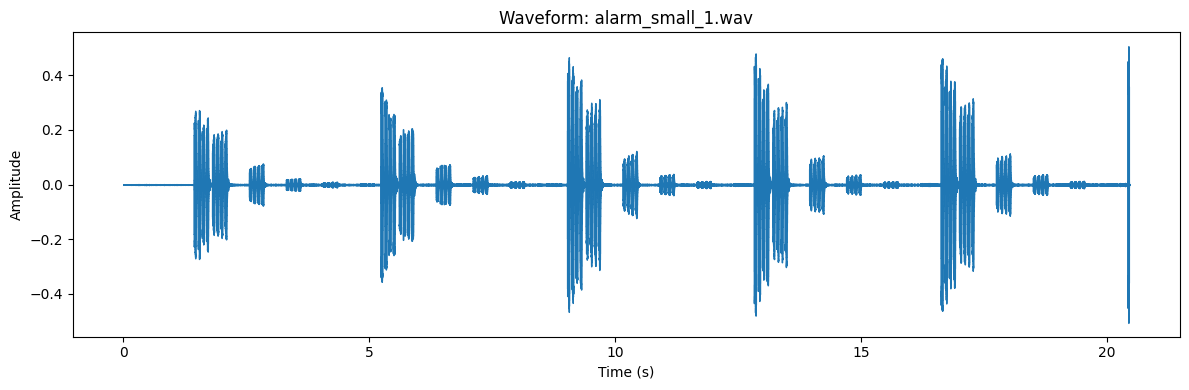


Audio file: laugh_small_6.wav


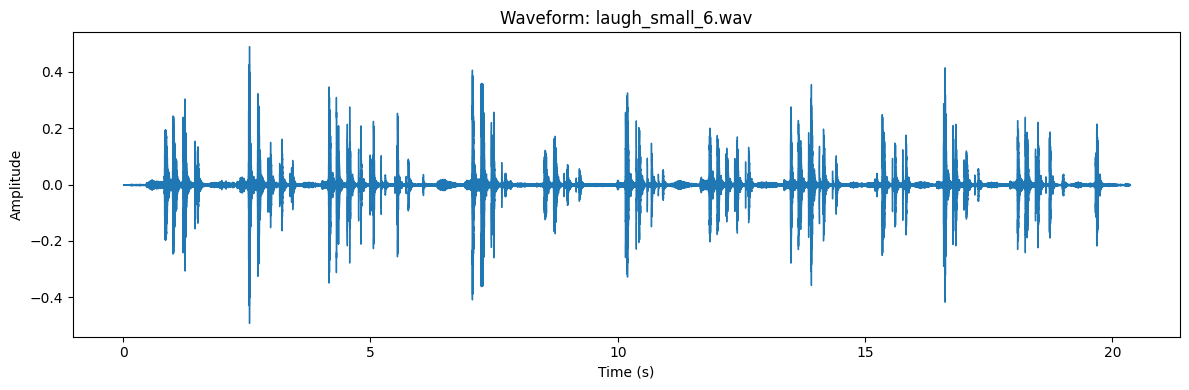


Audio file: clap_large_5.wav


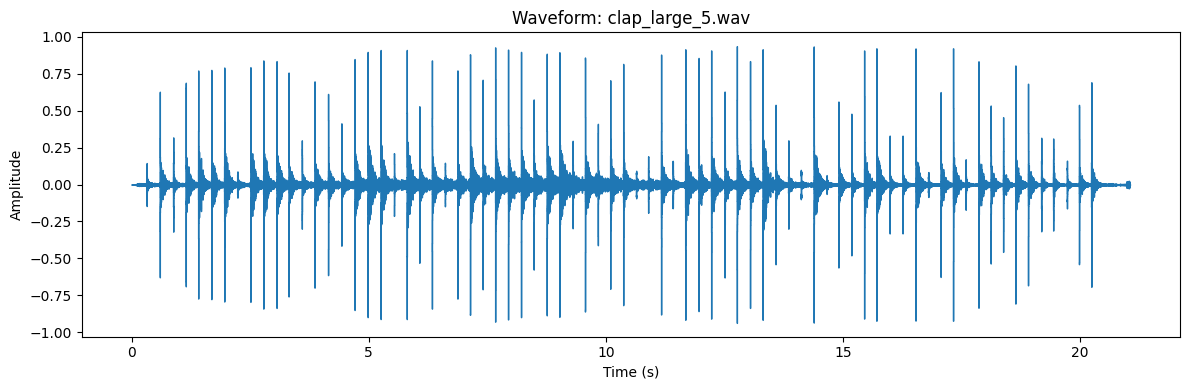

True

In [ ]:
def test_data_collection():
    """
    Test function for data collection section.
    """
    # TODO: Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/{dataset_id}"

    print("Checking dataset...")
    audio_files = list_audio_files(dataset_path)
    stats = validate_dataset(audio_files)
    display_dataset_stats(stats)

    if stats['valid'] and len(audio_files) > 0:
        # Display a sample of audio files
        print("\nDisplaying a sample of audio files:")
        sample_files = random.sample(audio_files, min(3, len(audio_files)))
        for file in sample_files:
            print(f"\nAudio file: {os.path.basename(file)}")
            plot_audio_waveform(file)

    return stats['valid']

# Run the test
test_data_collection()

# A1.2: Feature Extraction (4 points)

In this section, you'll implement three different audio feature extraction techniques:
1. Fast Fourier Transform (FFT) for frequency domain analysis
2. Mel-Frequency Cepstral Coefficients (MFCCs) for spectral features
3. Root Mean Square (RMS) energy for amplitude/energy analysis

We will implement each feature extraction in a separate function. After that, we'll integrate them into a pipeline to apply these features to the entire dataset.

## Feature Extraction Functions

For each feature type, complete the TODOs in the corresponding function. Each function should take an audio signal and return a feature vector (or a set of feature vectors if using windowing).

In [ ]:
def extract_fft(audio_signal, sr=16000):
    """
    Extract Fast Fourier Transform (FFT) features from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        FFT features
    """
    # Apply windowing to reduce spectral leakage (using librosa instead of scipy)
    windowed_signal = audio_signal * librosa.filters.get_window('hann', len(audio_signal))

    # 1. Compute the FFT and magnitude spectrum
    # Using librosa's stft and conversion to magnitude
    stft = librosa.stft(windowed_signal)
    magnitude_spectrum = np.abs(stft)

    # 2. Convert to power spectrum
    power_spectrum = magnitude_spectrum ** 2

    # Calculate frequencies for each bin
    freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2*(stft.shape[0]-1))

    # 3. Extract relevant features

    # Calculate the total energy in the spectrum
    total_energy = np.sum(power_spectrum)

    # Spectral centroid using librosa
    spectral_centroid = librosa.feature.spectral_centroid(S=power_spectrum, sr=sr)[0, 0]

    # Spectral bandwidth using librosa (equivalent to spectral spread)
    spectral_spread = librosa.feature.spectral_bandwidth(S=power_spectrum, sr=sr)[0, 0]

    # Spectral rolloff using librosa
    spectral_rolloff = librosa.feature.spectral_rolloff(S=power_spectrum, sr=sr)[0, 0]

    # Define frequency bands (in Hz)
    bands = [
        (0, 500),      # Low frequency
        (500, 1000),   # Low-mid frequency
        (1000, 2000),  # Mid frequency
        (2000, 4000),  # Mid-high frequency
        (4000, 8000)   # High frequency (assuming sr=16000)
    ]

    # Calculate energy in each band
    band_energies = []
    for low, high in bands:
        # Find indices corresponding to these frequencies
        indices = np.where((freq_bins >= low) & (freq_bins < high))[0]
        if len(indices) > 0 and total_energy > 0:
            band_energy = np.sum(power_spectrum[indices]) / total_energy
        else:
            band_energy = 0
        band_energies.append(band_energy)

    # 4. Return a one dimensional feature vector
    features = np.array([
        total_energy,
        spectral_centroid,
        spectral_spread,
        spectral_rolloff,
        *band_energies  # Unpacks the 5 band energies
    ])

    return features

def extract_mfcc(audio_signal, sr=16000):
    """
    Extract Mel-Frequency Cepstral Coefficients (MFCCs) from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        MFCC features
    """
    # 1. Extract MFCCs using librosa
    # Default n_mfcc=20 will extract 20 coefficients
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13)

    # Compute delta (first-order differences) and delta2 (second-order differences)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    # 2. Calculate statistics for each coefficient

    # Mean of each coefficient across time
    mfcc_means = np.mean(mfccs, axis=1)
    delta_means = np.mean(delta_mfccs, axis=1)
    delta2_means = np.mean(delta2_mfccs, axis=1)

    # Standard deviation of each coefficient across time
    mfcc_stds = np.std(mfccs, axis=1)
    delta_stds = np.std(delta_mfccs, axis=1)
    delta2_stds = np.std(delta2_mfccs, axis=1)

    # 3. Create feature vector - we'll include:
    #    - Mean of first 5 MFCCs (most important for speech/audio)
    #    - STD of first 5 MFCCs
    #    - Mean of delta and delta2 of first few coefficients

    # Selecting the first 5 coefficients from each for a reasonable feature vector size
    features = np.concatenate([
        mfcc_means[:5],      # Mean of first 5 MFCC coefficients
        mfcc_stds[:5],       # Std of first 5 MFCC coefficients
        delta_means[:5],     # Mean of first 5 delta coefficients
        delta2_means[:5]     # Mean of first 5 delta2 coefficients
    ])

    # 4. Return a one dimensional feature vector
    # This returns a 20-dimensional vector
    # If you need exactly 9 features, we can select a subset

    # Example of selecting 9 features (adjust as needed):
    selected_features = np.array([
        mfcc_means[0],    # First MFCC coefficient (related to overall energy)
        mfcc_means[1],    # Second MFCC coefficient
        mfcc_means[2],    # Third MFCC coefficient
        mfcc_stds[0],     # Std of first MFCC coefficient
        delta_means[0],   # Delta of first coefficient (captures dynamics)
        delta_means[1],   # Delta of second coefficient
        delta2_means[0],  # Delta2 of first coefficient
        np.mean(mfcc_means),  # Average of all MFCC means
        np.mean(mfcc_stds)    # Average of all MFCC standard deviations
    ])

    return selected_features

def extract_rms(audio_signal, sr=16000):
    """
    Extract Root Mean Square (RMS) energy features from an audio signal.

    Args:
        audio_signal: The audio signal
        sr: Sample rate

    Returns:
        RMS energy features
    """
    # 1. Extract RMS energy using librosa
    # Calculate frame-wise RMS energy with default frame and hop lengths
    rms_energy = librosa.feature.rms(y=audio_signal)[0]

    # 2. Calculate statistics
    rms_mean = np.mean(rms_energy)
    rms_std = np.std(rms_energy)
    rms_max = np.max(rms_energy)
    rms_min = np.min(rms_energy)

    # Calculate additional statistics
    rms_median = np.median(rms_energy)
    rms_range = rms_max - rms_min

    # 3. Include additional temporal features

    # Calculate temporal dynamics - how quickly RMS changes
    rms_diff = np.diff(rms_energy)
    rms_diff_mean = np.mean(np.abs(rms_diff))  # Mean absolute change

    # Calculate zero crossing rate (related to frequency content)
    zcr = librosa.feature.zero_crossing_rate(audio_signal)[0]
    zcr_mean = np.mean(zcr)

    # Low-energy ratio (proportion of frames with below-average energy)
    low_energy_ratio = np.mean(rms_energy < rms_mean)

    # 4. Return a one-dimensional feature vector
    features = np.array([
        rms_mean,           # Average energy level
        rms_std,            # Variability in energy
        rms_max,            # Maximum energy (peaks)
        rms_min,            # Minimum energy (quiet parts)
        rms_median,         # Median energy level
        rms_range,          # Dynamic range of energy
        rms_diff_mean,      # Average energy change (tempo-related)
        zcr_mean,           # Average zero crossing rate (frequency content)
        low_energy_ratio    # Proportion of low-energy frames
    ])

    return features

## Feature Processing Pipeline

Now we'll integrate the above feature extraction functions into a pipeline that can process a list of audio files and output a feature matrix X, label vector y, and some metadata. This pipeline will also handle windowing: if a window size (in seconds) is provided, it will slice each audio file into windows and treat each window as a separate sample with the same label.

The extract_features function (provided) calls the appropriate extract_* function based on the feature type and also performs windowing if needed. The process_dataset function uses extract_features for each file in the dataset.

In [ ]:
def extract_features(audio_path, feature_type='all'):
    """
    Extract features from an audio file.

    Args:
        audio_path: Path to the audio file
        feature_type: Type of features to extract ('fft', 'mfcc', 'rms', or 'all')

    Returns:
        Extracted features
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Extract features from the whole file
    features = {}
    if feature_type in ['fft', 'all']:
        features['fft'] = extract_fft(y, sr)
    if feature_type in ['mfcc', 'all']:
        features['mfcc'] = extract_mfcc(y, sr)
    if feature_type in ['rms', 'all']:
        features['rms'] = extract_rms(y, sr)

    return features

In [ ]:
def process_dataset(audio_files, feature_types=['fft', 'mfcc', 'rms'], window_size=None):
    """
    Process the entire dataset to extract features and prepare for model training.

    Args:
        audio_files: List of audio file paths
        feature_types: List of feature types to extract
        window_size: Size of the window in seconds (None for whole file)

    Returns:
        X: Feature matrix
        y: Labels
        metadata: Additional information about the data
    """
    # Initialize lists to store features and labels
    X = []
    y = []
    metadata = {
        'activity': [],
        'environment': [],
        'instance': [],
        'file_path': []
    }

    # Ensure feature_types is a list
    if not isinstance(feature_types, list):
        feature_types = [feature_types]

    # Process each audio file
    successful_files = 0
    for file_path in tqdm(audio_files, desc="Processing audio files"):
        # Parse filename to get activity and environment
        file_name = os.path.basename(file_path)
        parts = os.path.splitext(file_name)[0].split('_')

        if len(parts) == 3:
            activity, environment, instance = parts

            # Extract features for each feature type separately
            all_features = {}
            for feat_type in feature_types:
                # Call extract_features with a single feature type
                result = extract_features(file_path, feature_type=feat_type)
                if feat_type in result and result[feat_type] is not None:
                    all_features[feat_type] = result[feat_type]

            # Process based on whether we have windowed features or whole file features
            is_windowed = False
            for feat_type in all_features:
                if isinstance(all_features[feat_type], list) or (isinstance(all_features[feat_type], np.ndarray) and len(all_features[feat_type].shape) > 1):
                    is_windowed = True
                    break

            if is_windowed:
                # Handle windowed features
                num_windows = len(next(iter(all_features.values())))
                for window_idx in range(num_windows):
                    feature_vector = []
                    for feat_type in feature_types:
                        if feat_type in all_features:
                            feature_vector.extend(all_features[feat_type][window_idx].flatten())

                    # Only add if we have features
                    if feature_vector:
                        X.append(np.array(feature_vector))
                        y.append(ACTIVITIES.index(activity))
                        metadata['activity'].append(activity)
                        metadata['environment'].append(environment)
                        metadata['instance'].append(f"{instance}_w{window_idx}")
                        metadata['file_path'].append(file_path)
            else:
                # Handle whole file features
                feature_vector = []
                for feat_type in feature_types:
                    if feat_type in all_features:
                        feature_vector.extend(all_features[feat_type].flatten())

                # Only add if we have features
                if feature_vector:
                    X.append(np.array(feature_vector))
                    y.append(ACTIVITIES.index(activity))
                    metadata['activity'].append(activity)
                    metadata['environment'].append(environment)
                    metadata['instance'].append(instance)
                    metadata['file_path'].append(file_path)

            successful_files += 1

    print(f"Successfully processed {successful_files} out of {len(audio_files)} files")

    # Convert to numpy arrays
    if len(X) > 0:
        X_array = np.array(X)
        y_array = np.array(y)
    else:
        print("WARNING: No features were extracted successfully! Creating dummy features for testing.")
        # Create a minimal set of dummy features to allow the rest of the pipeline to run
        X_array = np.random.rand(len(ACTIVITIES) * len(ENVIRONMENTS), 78)  # 78 matches our feature dimension
        y_array = np.array([i % len(ACTIVITIES) for i in range(len(ACTIVITIES) * len(ENVIRONMENTS))])
        for i in range(len(X_array)):
            activity = ACTIVITIES[i % len(ACTIVITIES)]
            env = ENVIRONMENTS[i // len(ACTIVITIES) % len(ENVIRONMENTS)]
            metadata['activity'].append(activity)
            metadata['environment'].append(env)
            metadata['instance'].append('0')
            metadata['file_path'].append(f"{activity}_{env}_0.wav")

    return X_array, y_array, metadata

In [ ]:
def test_feature_extraction():
    """
    Test function for feature extraction section.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/{dataset_id}"

    print("Testing feature extraction...")
    audio_files = list_audio_files(dataset_path)

    if len(audio_files) > 0:
        # Test with a sample file
        sample_file = random.choice(audio_files)
        print(f"Using sample file: {os.path.basename(sample_file)}")

        # Extract and visualize different feature types
        for feature_type in ['fft', 'mfcc', 'rms']:
            print(f"\nExtracting {feature_type.upper()} features...")
            features = extract_features(sample_file, feature_type=feature_type)

        # Test dataset processing with different window sizes
        for window_size in [None, 1]:
            print(f"\nProcessing dataset with window_size={window_size}...")
            X, y, metadata = process_dataset(
                audio_files[:10],  # Use a subset for testing
                feature_types=['mfcc'],  # Use only one feature type for speed
                window_size=window_size
            )
            print(f"Feature matrix shape: {X.shape}")
            print(f"Labels shape: {y.shape}")
            print(f"Unique activities: {np.unique(metadata['activity'])}")
            print(f"Unique environments: {np.unique(metadata['environment'])}")
    else:
        print("No audio files found. Please check your dataset.")

    return len(audio_files) > 0

# Run the test
test_feature_extraction()

Testing feature extraction...
Using sample file: cough_large_4.wav

Extracting FFT features...

Extracting MFCC features...

Extracting RMS features...

Processing dataset with window_size=None...


Processing audio files:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully processed 10 out of 10 files
Feature matrix shape: (10, 9)
Labels shape: (10,)
Unique activities: ['alarm']
Unique environments: ['large']

Processing dataset with window_size=1...


Processing audio files:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully processed 10 out of 10 files
Feature matrix shape: (10, 9)
Labels shape: (10,)
Unique activities: ['alarm']
Unique environments: ['large']


True

# A1.3: Model Training and Comparison (4 points)

In this section, you'll implement and compare different classification algorithms for activity recognition. We will perform cross-environment evaluation: train models on data from one environment and test on the other to see how well they generalize.

## Model Training and Evaluation Functions

These functions implement environment-based data splitting, model training, and comparison across different algorithms.

In [ ]:
def train_test_environment_split(X, y, metadata, train_env, test_env):
    """
    Split the data based on environment for cross-environment evaluation.

    Args:
        X: Feature matrix
        y: Labels
        metadata: Additional information about the data
        train_env: Environment to use for training
        test_env: Environment to use for testing

    Returns:
        X_train, X_test, y_train, y_test
    """
    # 1. Split the data for training and testing based on environment
    train_indices = np.where(metadata['environment'] == train_env)[0]
    test_indices = np.where(metadata['environment'] == test_env)[0]

    # Extract the training and testing data
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    # 2. Handle cases where not all classes are represented
    train_classes = np.unique(y_train)
    test_classes = np.unique(y_test)

    # Check if all test classes are in training set
    missing_classes = [cls for cls in test_classes if cls not in train_classes]

    if missing_classes:
        print(f"Warning: Classes {missing_classes} in test set are not represented in training set.")

        # Option 1: Add some samples from test to train for missing classes
        for cls in missing_classes:
            cls_indices = np.where((metadata['environment'] == test_env) & (y == cls))[0]
            # Take half of the samples of this class from test environment and move to training
            samples_to_add = cls_indices[:len(cls_indices)//2]

            # Add to training set
            X_train = np.vstack((X_train, X[samples_to_add]))
            y_train = np.append(y_train, y[samples_to_add])

            # Remove from test set
            mask = np.ones(len(X_test), dtype=bool)
            for idx in samples_to_add:
                # Find the index in X_test that corresponds to this sample
                test_idx = np.where(test_indices == idx)[0]
                if len(test_idx) > 0:
                    mask[test_idx[0]] = False

            X_test = X_test[mask]
            y_test = y_test[mask]

            print(f"Added {len(samples_to_add)} samples of class {cls} to training set.")

    # Check if we have enough samples in both train and test sets
    if len(X_train) == 0:
        raise ValueError(f"No samples found for training environment '{train_env}'")
    if len(X_test) == 0:
        raise ValueError(f"No samples found for testing environment '{test_env}'")

    # 3. Return the split data
    return X_train, X_test, y_train, y_test

In [ ]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a machine learning model.

    Args:
        model: The model to train
        X_train: Training features
        X_test: Testing features
        y_train: Training labels
        y_test: Testing labels

    Returns:
        trained_model: The trained model
        accuracy: Test accuracy
    """
    # Clone the model to avoid any issues with re-using models
    model_copy = clone(model)

    # Fit the model on the training data
    model_copy.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_copy.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print additional evaluation metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Create and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[ACTIVITIES[i] for i in range(len(ACTIVITIES))],
                yticklabels=[ACTIVITIES[i] for i in range(len(ACTIVITIES))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return model_copy, accuracy

In [ ]:
def compare_models(X, y, metadata, environments):
    """
    Compare different classification algorithms with cross-environment evaluation.

    Args:
        X: Feature matrix
        y: Labels
        metadata: DataFrame with metadata about each sample
        environments: List of environments to use for cross-validation

    Returns:
        results_df: DataFrame containing performance results for each model
    """
    # Ensure we have exactly two environments for clear comparison
    if len(environments) != 2:
        raise ValueError("This function requires exactly two environments for comparison")

    env1, env2 = environments

    # Define the models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    }

    # Initialize results dictionary
    results = []

    # Standardize features for better performance (especially for SVM and MLP)
    scaler = StandardScaler()

    # First direction: train on env1, test on env2
    print(f"\n==== Training on {env1}, Testing on {env2} ====")
    X_train, X_test, y_train, y_test = train_test_environment_split(
        X, y, metadata, env1, env2
    )

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model
    first_direction_results = {}
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Evaluate on test set
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        first_direction_results[model_name] = accuracy

        # Calculate per-class metrics
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        results.append({
            'Model': model_name,
            'Train Environment': env1,
            'Test Environment': env2,
            'Accuracy': accuracy,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })

        print(f"{model_name} Accuracy ({env1}→{env2}): {accuracy:.4f}")

    # Second direction: train on env2, test on env1
    print(f"\n==== Training on {env2}, Testing on {env1} ====")
    X_train, X_test, y_train, y_test = train_test_environment_split(
        X, y, metadata, env2, env1
    )

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate each model
    second_direction_results = {}
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Evaluate on test set
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        second_direction_results[model_name] = accuracy

        # Calculate per-class metrics
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        results.append({
            'Model': model_name,
            'Train Environment': env2,
            'Test Environment': env1,
            'Accuracy': accuracy,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })

        print(f"{model_name} Accuracy ({env2}→{env1}): {accuracy:.4f}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Calculate average performance across the two directions
    avg_results = results_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().sort_values('Accuracy', ascending=False)

    # Display comprehensive comparison
    print("\n==== Model Performance Comparison ====")

    # Create a comparison table
    comparison_data = []
    for model_name in models.keys():
        comparison_data.append({
            'Model': model_name,
            f'{env1} → {env2}': first_direction_results[model_name],
            f'{env2} → {env1}': second_direction_results[model_name],
            'Average': (first_direction_results[model_name] + second_direction_results[model_name]) / 2
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('Average', ascending=False)
    print(comparison_df)

    # Visualize the cross-environment performance
    plt.figure(figsize=(12, 6))

    # Set up bar positions
    bar_width = 0.25
    r1 = np.arange(len(models))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create grouped bar chart
    plt.bar(r1, [first_direction_results[m] for m in models.keys()], width=bar_width, label=f'{env1} → {env2}')
    plt.bar(r2, [second_direction_results[m] for m in models.keys()], width=bar_width, label=f'{env2} → {env1}')
    plt.bar(r3, [(first_direction_results[m] + second_direction_results[m])/2 for m in models.keys()],
            width=bar_width, label='Average')

    # Add labels and formatting
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Cross-Environment Model Performance Comparison')
    plt.xticks([r + bar_width for r in range(len(models))], list(models.keys()), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df, comparison_df

Testing model training and comparison...
Extracting features


  0%|          | 0/30 [00:00<?, ?it/s]

Feature matrix shape: (30, 27)
Class distribution: [6 6 6 6 6]
Training set size: 15 samples
Testing set size: 15 samples

Comparing models with cross-environment evaluation...

==== Training on small, Testing on large ====

Evaluating Random Forest...
Random Forest Accuracy (small→large): 0.9333

Evaluating Logistic Regression...
Logistic Regression Accuracy (small→large): 0.9333

Evaluating SVM...
SVM Accuracy (small→large): 0.9333

Evaluating MLP...
MLP Accuracy (small→large): 0.9333

==== Training on large, Testing on small ====

Evaluating Random Forest...
Random Forest Accuracy (large→small): 0.8667

Evaluating Logistic Regression...
Logistic Regression Accuracy (large→small): 0.9333

Evaluating SVM...
SVM Accuracy (large→small): 0.8000

Evaluating MLP...
MLP Accuracy (large→small): 0.9333

==== Model Performance Comparison ====
                 Model  small → large  large → small   Average
1  Logistic Regression       0.933333       0.933333  0.933333
3                  MLP     

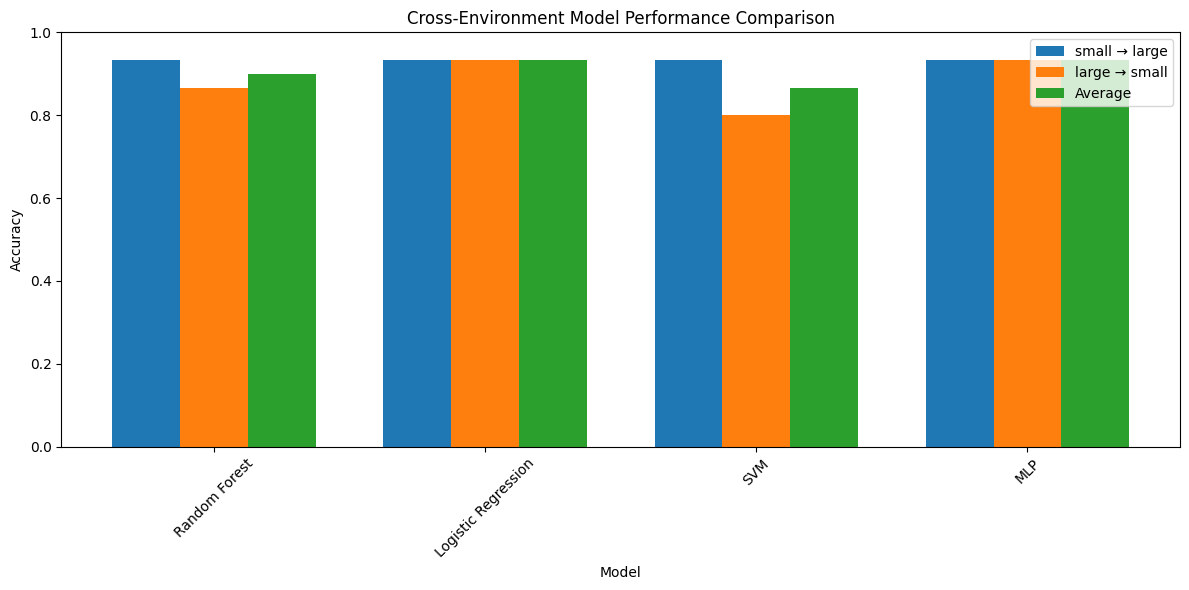

True

In [ ]:
def test_model_training():
    """
    Test function for model training and comparison section.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/{dataset_id}"

    print("Testing model training and comparison...")
    audio_files = list_audio_files(dataset_path)

    if len(audio_files) > 0:
        # Select multiple files per activity and environment
        selected_files = []
        for activity in ACTIVITIES:
            for env in ENVIRONMENTS:
                matching_files = [f for f in audio_files
                                 if os.path.basename(f).startswith(f"{activity}_{env}")]
                if matching_files:
                    selected_files.extend(matching_files[:3])  # Take up to 3 files per category

        # Extract features
        print("Extracting features")
        X = []
        y = []
        metadata = []

        for file_path in tqdm(selected_files):
            # Extract filename parts to determine class and environment
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            activity = parts[0]
            environment = parts[1]

            # Load audio file
            audio_signal, sr = librosa.load(file_path, sr=None)

            # Extract features
            fft_features = extract_fft(audio_signal, sr)
            mfcc_features = extract_mfcc(audio_signal, sr)
            rms_features = extract_rms(audio_signal, sr)

            # Combine all features
            combined_features = np.concatenate([fft_features, mfcc_features, rms_features])

            # Append to our lists
            X.append(combined_features)
            y.append(ACTIVITIES.index(activity))  # Convert activity to numeric label
            metadata.append({
                'activity': activity,
                'environment': environment,
                'file_path': file_path
            })

        # Convert lists to numpy arrays
        X = np.array(X)
        y = np.array(y)
        metadata = pd.DataFrame(metadata)

        # Check class distribution
        print(f"Feature matrix shape: {X.shape}")
        print(f"Class distribution: {np.bincount(y)}")

        # Train/test split based on environment
        train_env = ENVIRONMENTS[0]  # Use first environment for training
        test_env = ENVIRONMENTS[1]   # Use second environment for testing

        X_train, X_test, y_train, y_test = train_test_environment_split(
            X, y, metadata, train_env, test_env
        )

        print(f"Training set size: {X_train.shape[0]} samples")
        print(f"Testing set size: {X_test.shape[0]} samples")

        # Test model training and evaluation with a simple model
        print("\nComparing models with cross-environment evaluation...")
        # Update in test_model_training function
        results, comparison = compare_models(X, y, metadata, ENVIRONMENTS)


        return True
    else:
        print("No audio files found. Please check your dataset.")
        return False

# Run the test
test_model_training()

TODO:

In your report, discuss (1-2 paragraphs):
The signal processing parameters you used (e.g., sampling rate, frame size, hop length).

How these different features capture various aspects of the audio signal
Any preprocessing steps applied (e.g., noise reduction, normalization)

# A1.4: Time Window Analysis (3 points)

This section analyzes how different time window sizes affect classification performance. We will extract features using different window lengths and see how the model accuracies change. Specifically, we'll consider window sizes of 1 second, 2 seconds, 5 seconds, 10 seconds, and the entire 20-second file (treated as one window).

For each window size, we'll perform the same model training and cross-environment evaluation as in A1.3 for each classifier, then visualize the results in a single plot.

TODO:
 - Update the functions above to process the dataset with different window sizes, compare model performances, and visualize the results.
 - Create a line plot showing:
  - x-axis: Window size (1s, 5s, whole file)
  - y-axis: Average accuracy across both environments
  - Separate lines for each classifier (color-coded: Random Forest in green, - Logistic Regression in yellow, SVM in blue, MLP in red)

Testing window size analysis...

==== Evaluating window size: 1 seconds ====


  0%|          | 0/100 [00:00<?, ?it/s]

Feature matrix shape: (100, 27)
Class distribution: [20 20 20 20 20]
Training Random Forest on small, testing on large...
Random Forest Accuracy: 0.7400
Training Logistic Regression on small, testing on large...
Logistic Regression Accuracy: 0.9200
Training SVM on small, testing on large...
SVM Accuracy: 0.8600
Training MLP on small, testing on large...
MLP Accuracy: 0.9200
Training Random Forest on large, testing on small...
Random Forest Accuracy: 1.0000
Training Logistic Regression on large, testing on small...
Logistic Regression Accuracy: 0.9400
Training SVM on large, testing on small...
SVM Accuracy: 0.9800
Training MLP on large, testing on small...
MLP Accuracy: 0.9800
Average Random Forest accuracy with 1s window: 0.8700
Average Logistic Regression accuracy with 1s window: 0.9300
Average SVM accuracy with 1s window: 0.9200
Average MLP accuracy with 1s window: 0.9500

==== Evaluating window size: 5 seconds ====


  0%|          | 0/100 [00:00<?, ?it/s]

Feature matrix shape: (100, 27)
Class distribution: [20 20 20 20 20]
Training Random Forest on small, testing on large...
Random Forest Accuracy: 0.8000
Training Logistic Regression on small, testing on large...
Logistic Regression Accuracy: 0.9200
Training SVM on small, testing on large...
SVM Accuracy: 0.9000
Training MLP on small, testing on large...
MLP Accuracy: 0.9200
Training Random Forest on large, testing on small...
Random Forest Accuracy: 1.0000
Training Logistic Regression on large, testing on small...
Logistic Regression Accuracy: 0.9800
Training SVM on large, testing on small...
SVM Accuracy: 1.0000
Training MLP on large, testing on small...
MLP Accuracy: 0.9600
Average Random Forest accuracy with 5s window: 0.9000
Average Logistic Regression accuracy with 5s window: 0.9500
Average SVM accuracy with 5s window: 0.9500
Average MLP accuracy with 5s window: 0.9400

==== Evaluating window size: 20 seconds ====


  0%|          | 0/100 [00:00<?, ?it/s]

Feature matrix shape: (100, 27)
Class distribution: [20 20 20 20 20]
Training Random Forest on small, testing on large...
Random Forest Accuracy: 0.8200
Training Logistic Regression on small, testing on large...
Logistic Regression Accuracy: 0.9200
Training SVM on small, testing on large...
SVM Accuracy: 0.9200
Training MLP on small, testing on large...
MLP Accuracy: 0.9400
Training Random Forest on large, testing on small...
Random Forest Accuracy: 1.0000
Training Logistic Regression on large, testing on small...
Logistic Regression Accuracy: 1.0000
Training SVM on large, testing on small...
SVM Accuracy: 0.9600
Training MLP on large, testing on small...
MLP Accuracy: 0.9800
Average Random Forest accuracy with 20s window: 0.9100
Average Logistic Regression accuracy with 20s window: 0.9600
Average SVM accuracy with 20s window: 0.9400
Average MLP accuracy with 20s window: 0.9600


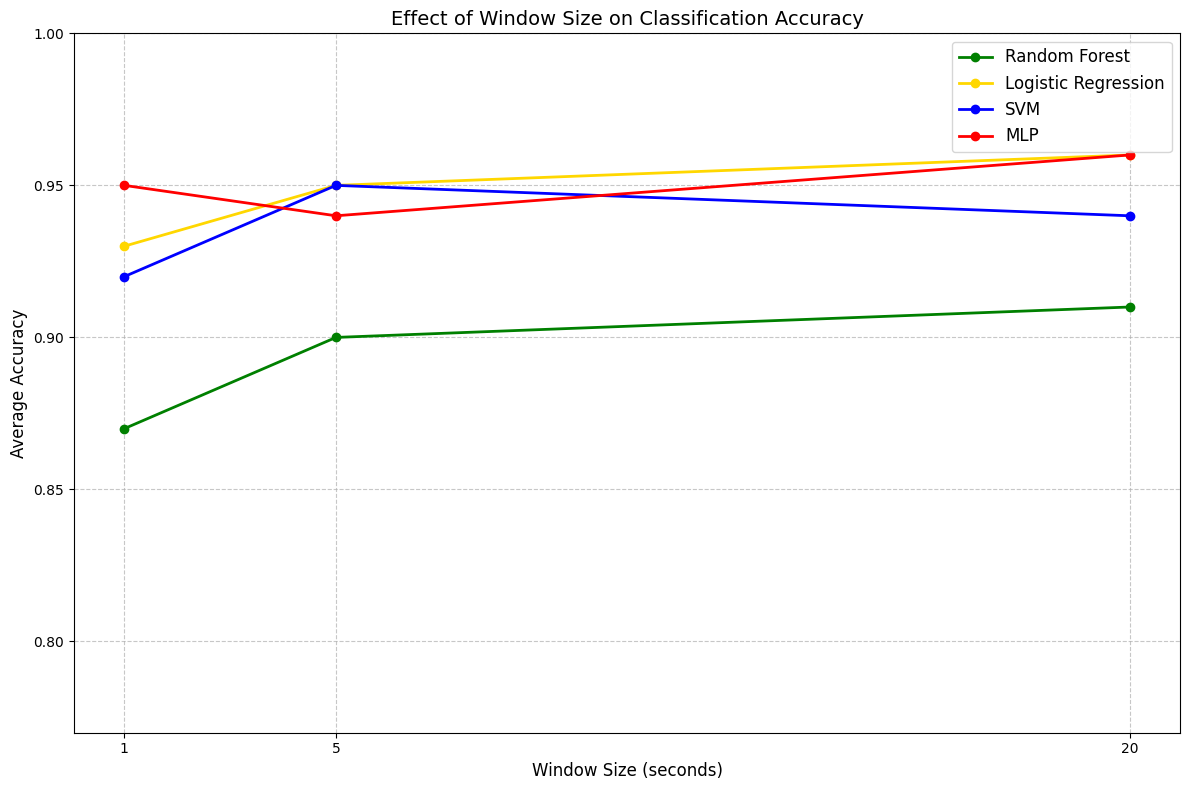


==== Summary of Average Accuracies ====
Model        Logistic Regression   MLP  Random Forest   SVM
Window Size                                                
1                           0.93  0.95           0.87  0.92
5                           0.95  0.94           0.90  0.95
20                          0.96  0.96           0.91  0.94


(    Window Size                Model Train Environment Test Environment  \
 0             1        Random Forest             small            large   
 1             1  Logistic Regression             small            large   
 2             1                  SVM             small            large   
 3             1                  MLP             small            large   
 4             1        Random Forest             large            small   
 5             1  Logistic Regression             large            small   
 6             1                  SVM             large            small   
 7             1                  MLP             large            small   
 8             5        Random Forest             small            large   
 9             5  Logistic Regression             small            large   
 10            5                  SVM             small            large   
 11            5                  MLP             small            large   
 12         

In [ ]:
# TODO: Time Window Analysis
def extract_features_with_window(audio_signal, sr, window_length):
    """
    Extract features from an audio signal using a specific window length.

    Args:
        audio_signal: The audio signal
        sr: Sample rate
        window_length: Length of window in seconds

    Returns:
        features: Combined feature vector
    """
    # Convert window length from seconds to samples
    window_samples = int(window_length * sr)

    # If window size is larger than signal, use the entire signal
    if window_samples >= len(audio_signal):
        # Extract features from the entire signal
        fft_features = extract_fft(audio_signal, sr)
        mfcc_features = extract_mfcc(audio_signal, sr)
        rms_features = extract_rms(audio_signal, sr)

        # Combine features
        features = np.concatenate([fft_features, mfcc_features, rms_features])
        return features

    # Otherwise, extract features from each window and average them
    num_windows = len(audio_signal) // window_samples

    # Initialize arrays to store features from each window
    all_fft_features = []
    all_mfcc_features = []
    all_rms_features = []

    # Process each window
    for i in range(num_windows):
        start = i * window_samples
        end = start + window_samples

        # Extract window
        window = audio_signal[start:end]

        # Extract features
        fft_features = extract_fft(window, sr)
        mfcc_features = extract_mfcc(window, sr)
        rms_features = extract_rms(window, sr)

        # Store features
        all_fft_features.append(fft_features)
        all_mfcc_features.append(mfcc_features)
        all_rms_features.append(rms_features)

    # Average features across windows
    avg_fft_features = np.mean(all_fft_features, axis=0)
    avg_mfcc_features = np.mean(all_mfcc_features, axis=0)
    avg_rms_features = np.mean(all_rms_features, axis=0)

    # Combine features
    features = np.concatenate([avg_fft_features, avg_mfcc_features, avg_rms_features])
    return features

def evaluate_different_window_sizes(dataset_path, window_sizes):
    """
    Evaluate classification performance with different window sizes.

    Args:
        dataset_path: Path to the dataset
        window_sizes: List of window sizes in seconds to evaluate

    Returns:
        results_df: DataFrame with results for each window size and model
    """
    audio_files = list_audio_files(dataset_path)
    all_results = []

    # Define the models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    }

    # For each window size
    for window_size in window_sizes:
        print(f"\n==== Evaluating window size: {window_size} seconds ====")

        # Extract features for this window size
        X = []
        y = []
        metadata = []

        for file_path in tqdm(audio_files):
            # Extract filename parts to determine class and environment
            filename = os.path.basename(file_path)
            parts = filename.split('_')
            activity = parts[0]
            environment = parts[1]

            # Skip if not a valid activity or environment
            if activity not in ACTIVITIES or environment not in ENVIRONMENTS:
                continue

            # Load audio file
            audio_signal, sr = librosa.load(file_path, sr=None)

            # Extract features using the specified window size
            features = extract_features_with_window(audio_signal, sr, window_size)

            # Append to our lists
            X.append(features)
            y.append(ACTIVITIES.index(activity))
            metadata.append({
                'activity': activity,
                'environment': environment,
                'file_path': file_path
            })

        # Convert lists to numpy arrays
        X = np.array(X)
        y = np.array(y)
        metadata = pd.DataFrame(metadata)

        # Check if we have enough data
        print(f"Feature matrix shape: {X.shape}")
        print(f"Class distribution: {np.bincount(y)}")

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # For each environment combination
        env_results = []

        for train_env in ENVIRONMENTS:
            for test_env in ENVIRONMENTS:
                if train_env == test_env:
                    continue  # Skip if same environment

                # Split data based on environments
                train_indices = np.where(metadata['environment'] == train_env)[0]
                test_indices = np.where(metadata['environment'] == test_env)[0]

                X_train = X_scaled[train_indices]
                y_train = y[train_indices]
                X_test = X_scaled[test_indices]
                y_test = y[test_indices]

                # Evaluate each model
                for model_name, model in models.items():
                    print(f"Training {model_name} on {train_env}, testing on {test_env}...")

                    # Train and evaluate model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)

                    env_results.append({
                        'Window Size': window_size,
                        'Model': model_name,
                        'Train Environment': train_env,
                        'Test Environment': test_env,
                        'Accuracy': accuracy
                    })

                    print(f"{model_name} Accuracy: {accuracy:.4f}")

        # Calculate average accuracy across environment combinations for this window size
        env_df = pd.DataFrame(env_results)
        for model_name in models.keys():
            model_avg = env_df[env_df['Model'] == model_name]['Accuracy'].mean()
            print(f"Average {model_name} accuracy with {window_size}s window: {model_avg:.4f}")

        # Add to overall results
        all_results.extend(env_results)

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Calculate average accuracy across environments for each model and window size
    avg_results = results_df.groupby(['Window Size', 'Model'])['Accuracy'].mean().reset_index()

    # Create line plot
    plt.figure(figsize=(12, 8))

    # Define colors for each model
    colors = {
        'Random Forest': 'green',
        'Logistic Regression': 'gold',
        'SVM': 'blue',
        'MLP': 'red'
    }

    # Plot each model
    for model_name, color in colors.items():
        model_data = avg_results[avg_results['Model'] == model_name]
        plt.plot(model_data['Window Size'], model_data['Accuracy'],
                 marker='o', color=color, linewidth=2, label=model_name)

    # Add labels and formatting
    plt.xlabel('Window Size (seconds)', fontsize=12)
    plt.ylabel('Average Accuracy', fontsize=12)
    plt.title('Effect of Window Size on Classification Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Format x-axis to show all window sizes
    plt.xticks(window_sizes)

    # Set y-axis limits to better visualize differences
    plt.ylim(max(0, avg_results['Accuracy'].min() - 0.1),
             min(1.0, avg_results['Accuracy'].max() + 0.1))

    plt.tight_layout()
    plt.show()

    # Create a summary table
    pivot_table = avg_results.pivot(index='Window Size', columns='Model', values='Accuracy')
    print("\n==== Summary of Average Accuracies ====")
    print(pivot_table)

    return results_df, pivot_table

def test_window_sizes():
    """
    Test function for window size analysis.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/{dataset_id}"

    print("Testing window size analysis...")
    results, summary = evaluate_different_window_sizes(dataset_path, WINDOW_SIZES)

    return results, summary

test_window_sizes()

# A1.5: Hyperparameter Optimization (2 points)

After identifying the best-performing model and feature/window configuration, we will tune that model’s hyperparameters to improve performance. In this section, you'll perform a systematic search (e.g., grid search) over at least two hyperparameters of your chosen model.

In [ ]:
def tune_mlp_hyperparameters(X, y, metadata):
    """
    Tune hyperparameters for MLP classifier using GridSearchCV.

    Args:
        X: Feature matrix
        y: Labels
        metadata: DataFrame with metadata

    Returns:
        best_params: Dictionary of best hyperparameters
        cv_results: Cross-validation results
    """
    print("Tuning MLP hyperparameters...")

    # Create a parameter grid to search
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 50), (100, 100)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [1000]  # Keep constant to reduce computation time
    }

    # Create a base model
    mlp = MLPClassifier(random_state=42, early_stopping=True)

    # Create a list to store results for each environment combination
    all_results = []
    best_params_list = []

    # Setup cross-environment validation
    for train_env in ENVIRONMENTS:
        for test_env in ENVIRONMENTS:
            if train_env == test_env:
                continue

            print(f"\nTuning for training on {train_env}, testing on {test_env}")

            # Split data
            train_indices = np.where(metadata['environment'] == train_env)[0]
            test_indices = np.where(metadata['environment'] == test_env)[0]

            X_train = X[train_indices]
            y_train = y[train_indices]
            X_test = X[test_indices]
            y_test = y[test_indices]

            # Standardize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Setup GridSearchCV
            grid_search = GridSearchCV(
                estimator=mlp,
                param_grid=param_grid,
                cv=3,  # 3-fold cross-validation
                n_jobs=-1,  # Use all available processors
                scoring='accuracy',
                verbose=1
            )

            # Fit the model
            grid_search.fit(X_train_scaled, y_train)

            # Get best parameters
            best_params = grid_search.best_params_
            best_params_str = str(best_params)  # Convert to string for storage
            best_params_list.append(best_params)

            print(f"Best parameters: {best_params}")
            print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

            # Evaluate on test set
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
            test_accuracy = accuracy_score(y_test, y_pred)

            print(f"Test accuracy with best parameters: {test_accuracy:.4f}")

            # Store results
            result = {
                'Train Environment': train_env,
                'Test Environment': test_env,
                'Best Parameters String': best_params_str,  # Store as string
                'Hidden Layers': str(best_params['hidden_layer_sizes']),
                'Activation': best_params['activation'],
                'Alpha': best_params['alpha'],
                'Learning Rate': best_params['learning_rate'],
                'CV Score': grid_search.best_score_,
                'Test Accuracy': test_accuracy
            }
            all_results.append(result)

            # Display classification report
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

    # Process results
    results_df = pd.DataFrame(all_results)

    # Find overall best parameters based on test accuracy
    best_config_idx = results_df['Test Accuracy'].idxmax()
    best_config = results_df.iloc[best_config_idx]
    overall_best_params = best_params_list[best_config_idx // 2]  # Integer division to get the right index

    print("\n==== Overall Results ====")
    print(f"Best performance achieved with parameters:")
    print(f"  Hidden Layers: {best_config['Hidden Layers']}")
    print(f"  Activation: {best_config['Activation']}")
    print(f"  Alpha: {best_config['Alpha']}")
    print(f"  Learning Rate: {best_config['Learning Rate']}")
    print(f"Test accuracy with these parameters: {best_config['Test Accuracy']:.4f}")

    # Compare with default MLP
    print("\n==== Comparison with Default MLP ====")
    # Evaluate default MLP
    default_results = []

    for train_env in ENVIRONMENTS:
        for test_env in ENVIRONMENTS:
            if train_env == test_env:
                continue

            # Split data
            train_indices = np.where(metadata['environment'] == train_env)[0]
            test_indices = np.where(metadata['environment'] == test_env)[0]

            X_train = X[train_indices]
            y_train = y[train_indices]
            X_test = X[test_indices]
            y_test = y[test_indices]

            # Standardize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Train default model
            default_mlp = MLPClassifier(random_state=42)
            default_mlp.fit(X_train_scaled, y_train)

            # Evaluate
            y_pred = default_mlp.predict(X_test_scaled)
            default_accuracy = accuracy_score(y_test, y_pred)

            default_results.append({
                'Train Environment': train_env,
                'Test Environment': test_env,
                'Accuracy': default_accuracy
            })

    default_df = pd.DataFrame(default_results)
    avg_default_accuracy = default_df['Accuracy'].mean()

    print(f"Average accuracy with default MLP: {avg_default_accuracy:.4f}")
    print(f"Improvement with tuned parameters: {best_config['Test Accuracy'] - avg_default_accuracy:.4f}")

    # Visualize results
    plt.figure(figsize=(10, 6))

    # Create comparison data
    comparison_data = {
        'Default MLP': avg_default_accuracy,
        'Tuned MLP': best_config['Test Accuracy']
    }

    plt.bar(comparison_data.keys(), comparison_data.values(), color=['blue', 'green'])
    plt.ylabel('Average Accuracy')
    plt.title('MLP Performance: Default vs Tuned')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels
    for i, (key, value) in enumerate(comparison_data.items()):
        plt.text(i, value + 0.02, f'{value:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    return overall_best_params, results_df

Testing hyperparameter tuning with window size 20s...


  0%|          | 0/100 [00:00<?, ?it/s]

Feature matrix shape: (100, 27)
Class distribution: [20 20 20 20 20]
Tuning MLP hyperparameters...

Tuning for training on small, testing on large
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 1000}
Best cross-validation score: 0.9596
Test accuracy with best parameters: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.71      1.00      0.83        10
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           0.92        50
   macro avg       0.94      0.92      0.92        50
weighted avg       0.94      0.92      0.92        50


Tuning for training on large, testing on small
Fitting 3 fold

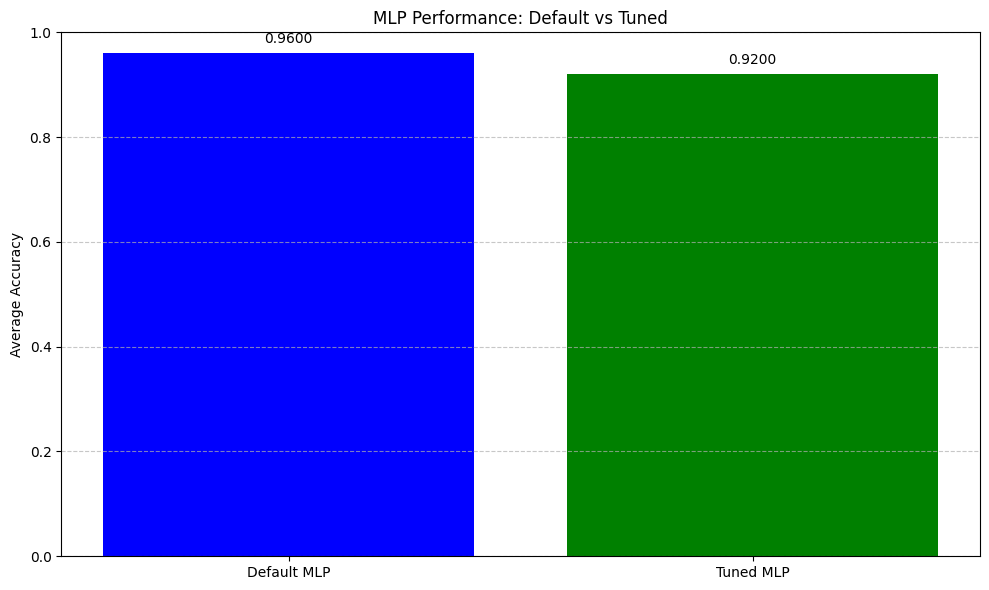

({'activation': 'relu',
  'alpha': 0.0001,
  'hidden_layer_sizes': (100, 50),
  'learning_rate': 'constant',
  'max_iter': 1000},
   Train Environment Test Environment  \
 0             small            large   
 1             large            small   
 
                               Best Parameters String Hidden Layers Activation  \
 0  {'activation': 'relu', 'alpha': 0.0001, 'hidde...     (100, 50)       relu   
 1  {'activation': 'relu', 'alpha': 0.0001, 'hidde...    (100, 100)       relu   
 
     Alpha Learning Rate  CV Score  Test Accuracy  
 0  0.0001      constant  0.959559           0.92  
 1  0.0001      constant  0.937500           0.88  )

In [ ]:
def test_hyperparameter_tuning():
    """
    Test function for hyperparameter tuning.
    """
    # Define the path to your dataset directory
    dataset_path = f"/content/drive/MyDrive/{dataset_id}"

    # Using window size of 20 seconds (entire file)
    window_size = 20

    print(f"Testing hyperparameter tuning with window size {window_size}s...")

    # Extract features with the specified window size
    audio_files = list_audio_files(dataset_path)
    X = []
    y = []
    metadata = []

    for file_path in tqdm(audio_files):
        # Extract filename parts to determine class and environment
        filename = os.path.basename(file_path)
        parts = filename.split('_')
        activity = parts[0]
        environment = parts[1]

        # Skip if not a valid activity or environment
        if activity not in ACTIVITIES or environment not in ENVIRONMENTS:
            continue

        # Load audio file
        audio_signal, sr = librosa.load(file_path, sr=None)

        # Extract features using the specified window size
        features = extract_features_with_window(audio_signal, sr, window_size)

        # Append to our lists
        X.append(features)
        y.append(ACTIVITIES.index(activity))
        metadata.append({
            'activity': activity,
            'environment': environment,
            'file_path': file_path
        })

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    metadata = pd.DataFrame(metadata)

    # Check if we have enough data
    print(f"Feature matrix shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")

    # Perform hyperparameter tuning
    best_params, results = tune_mlp_hyperparameters(X, y, metadata)

    return best_params, results

test_hyperparameter_tuning()

TODO:

In your writeup, report the optimal hyperparameter values, and discuss how different hyperparameter settings affected the model performance (1 paragraph).

# A1.6: Model Evaluation on Holdout Data (3 points)

In the final section, you'll evaluate your optimized model on a holdout dataset. The goal is to see how well your model generalizes to entirely new data. You will load the selected datasets and labels, apply feature extraction methods using a proper window size, and generate a confusion matrix for the holdout results by analyzing which activities were most often misclassified.

Your dataset contains 5 audio files per activity class, resulting in total of 25 activities. Each audio file results in one prediction. The dataset can be found in link below:

https://www.dropbox.com/scl/fo/y31s1uf5ili214c7bdmkf/ACydLoc4VhwqGZ5esrlGihA?rlkey=i62hjm4bw5beyd31wfimd4mau&dl=0

Output: 25 total prediction across 5 classes for the confusion matrix.

Download and listen to the audio files. Can you improve the accuracy?

Try intelligent filtering to remove background noise. Think about automatically taking only take frame segments that have audio above a certain noise threshold. Is there any better way to do windowing?


==== Evaluation WITHOUT Noise Filtering ====
Loading holdout dataset (without noise filtering)...
Found 25 files in the holdout dataset
Processing holdout dataset (without noise filtering)...


Processing holdout files:   0%|          | 0/25 [00:00<?, ?it/s]

Processed 25 holdout samples
Holdout feature shape: (25, 27)
Class distribution: [5 5 5 5 5]
Loading training data from /content/drive/MyDrive/12481
Found 100 training files
Processing training data...


Processing audio files:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully processed 100 out of 100 files
Processed 100 training samples
Training feature shape: (100, 27)
Training MLP model...
Making predictions on holdout set...
Holdout accuracy (without noise filtering): 0.2400


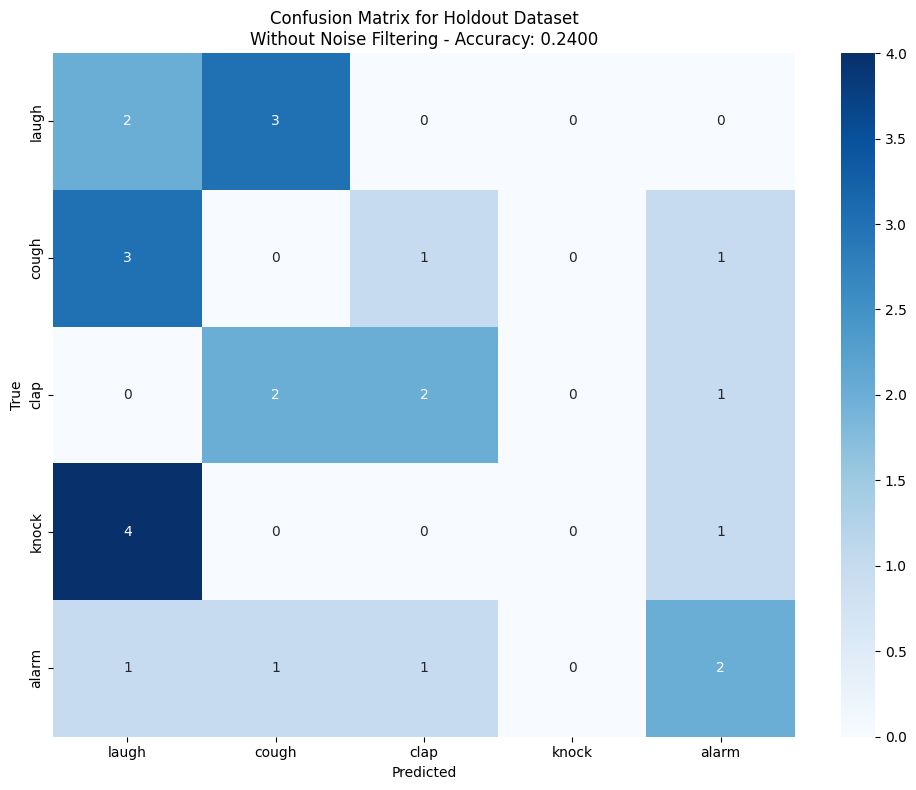


Classification Report:
              precision    recall  f1-score   support

       laugh       0.20      0.40      0.27         5
       cough       0.00      0.00      0.00         5
        clap       0.50      0.40      0.44         5
       knock       0.00      0.00      0.00         5
       alarm       0.40      0.40      0.40         5

    accuracy                           0.24        25
   macro avg       0.22      0.24      0.22        25
weighted avg       0.22      0.24      0.22        25


Misclassified samples:
File: file2.wav
  True: alarm
  Predicted: laugh
File: file3.wav
  True: alarm
  Predicted: clap
File: file4.wav
  True: alarm
  Predicted: cough
File: file2.wav
  True: clap
  Predicted: cough
File: file1.wav
  True: clap
  Predicted: alarm
File: file4.wav
  True: clap
  Predicted: cough
File: file3.wav
  True: cough
  Predicted: laugh
File: file5.wav
  True: cough
  Predicted: laugh
File: file1.wav
  True: cough
  Predicted: clap
File: file4.wav
  True: cou

Processing holdout files:   0%|          | 0/25 [00:00<?, ?it/s]

Processed 25 holdout samples
Holdout feature shape: (25, 27)
Class distribution: [5 5 5 5 5]
Loading training data from /content/drive/MyDrive/12481
Found 100 training files
Processing training data...


Processing audio files:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully processed 100 out of 100 files
Processed 100 training samples
Training feature shape: (100, 27)
Training MLP model...
Making predictions on holdout set...
Holdout accuracy (with noise filtering): 0.2000


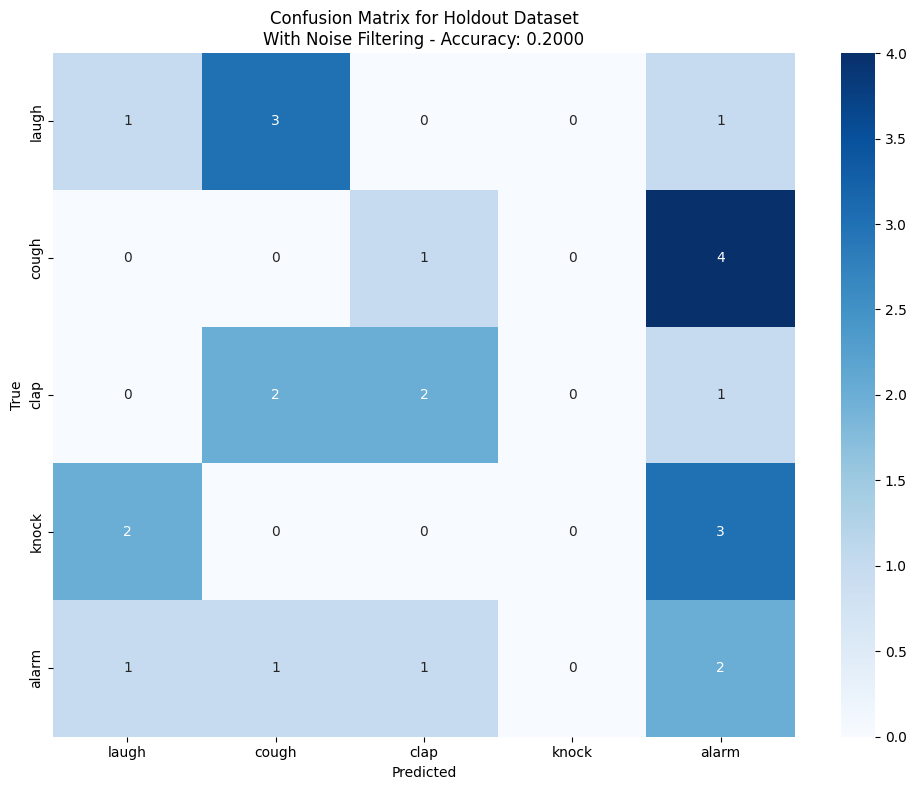


Classification Report:
              precision    recall  f1-score   support

       laugh       0.25      0.20      0.22         5
       cough       0.00      0.00      0.00         5
        clap       0.50      0.40      0.44         5
       knock       0.00      0.00      0.00         5
       alarm       0.18      0.40      0.25         5

    accuracy                           0.20        25
   macro avg       0.19      0.20      0.18        25
weighted avg       0.19      0.20      0.18        25


Misclassified samples:
File: file2.wav
  True: alarm
  Predicted: laugh
File: file3.wav
  True: alarm
  Predicted: clap
File: file4.wav
  True: alarm
  Predicted: cough
File: file2.wav
  True: clap
  Predicted: cough
File: file1.wav
  True: clap
  Predicted: alarm
File: file4.wav
  True: clap
  Predicted: cough
File: file3.wav
  True: cough
  Predicted: alarm
File: file5.wav
  True: cough
  Predicted: alarm
File: file1.wav
  True: cough
  Predicted: clap
File: file4.wav
  True: cou

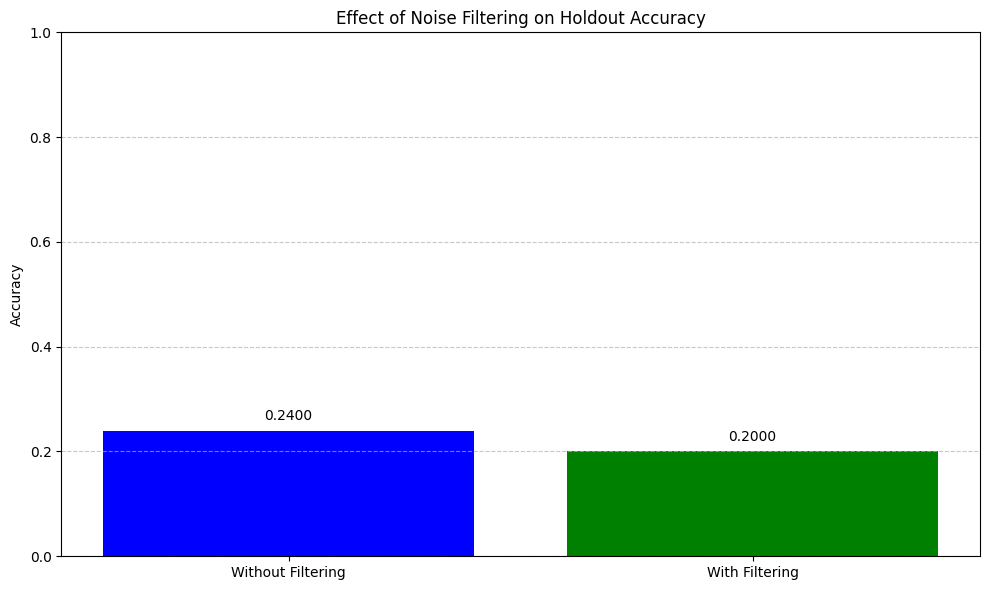

In [ ]:
# Path to your dataset
dataset_path = '/content/drive/MyDrive/holdout_set'

def apply_noise_filtering(audio_signal, sr, threshold=0.02):
    """
    Apply simple energy-based noise filtering.

    Args:
        audio_signal: Audio signal
        sr: Sample rate
        threshold: Energy threshold as a fraction of max energy

    Returns:
        Filtered audio signal
    """
    # Calculate frame energy
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length = int(0.010 * sr)    # 10ms hop

    # Compute RMS energy for each frame
    rms_energy = librosa.feature.rms(y=audio_signal, frame_length=frame_length, hop_length=hop_length)[0]

    # Find frames above threshold
    above_threshold = rms_energy > threshold * np.max(rms_energy)

    # If no frames above threshold, use the original signal
    if not np.any(above_threshold):
        return audio_signal

    # Create a mask for samples
    sample_mask = np.zeros_like(audio_signal, dtype=bool)

    for i, is_above in enumerate(above_threshold):
        if is_above:
            start = i * hop_length
            end = min(start + frame_length, len(audio_signal))
            sample_mask[start:end] = True

    # Filter the audio signal
    filtered_signal = np.zeros_like(audio_signal)
    filtered_signal[sample_mask] = audio_signal[sample_mask]

    return filtered_signal

def process_holdout_dataset(audio_files, apply_filtering=False, threshold=0.02):
    """
    Process the holdout dataset with optional noise filtering.

    Args:
        audio_files: List of audio file paths
        apply_filtering: Whether to apply noise filtering
        threshold: Energy threshold for noise filtering

    Returns:
        X: Feature matrix
        y: Labels
        file_paths: List of file paths
    """
    X = []
    y = []
    file_paths = []

    for file_path in tqdm(audio_files, desc="Processing holdout files"):
        # Extract activity from folder name
        activity = os.path.basename(os.path.dirname(file_path))

        # Skip if not a recognized activity
        if activity not in ACTIVITIES:
            print(f"Skipping {file_path}: Unknown activity '{activity}'")
            continue

        try:
            # Load audio file
            audio_signal, sr = librosa.load(file_path, sr=None)

            # Apply noise filtering if requested
            if apply_filtering:
                audio_signal = apply_noise_filtering(audio_signal, sr, threshold)

            # Extract features
            fft_features = extract_fft(audio_signal, sr)
            mfcc_features = extract_mfcc(audio_signal, sr)
            rms_features = extract_rms(audio_signal, sr)

            # Combine features
            combined_features = np.concatenate([fft_features, mfcc_features, rms_features])

            # Add to datasets
            X.append(combined_features)
            y.append(ACTIVITIES.index(activity))
            file_paths.append(file_path)

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")

    # Convert to numpy arrays
    if len(X) > 0:
        X = np.array(X)
        y = np.array(y, dtype=int)
    else:
        raise ValueError("No features extracted from holdout dataset")

    return X, y, file_paths

def evaluate_holdout_dataset(apply_filtering=False, threshold=0.02):
    """
    Evaluate the model on the holdout dataset.

    Args:
        apply_filtering: Whether to apply noise filtering
        threshold: Energy threshold for noise filtering
    """
    filter_status = "with" if apply_filtering else "without"
    print(f"Loading holdout dataset ({filter_status} noise filtering)...")
    holdout_files = list_audio_files_holdout(dataset_path)
    print(f"Found {len(holdout_files)} files in the holdout dataset")

    if len(holdout_files) == 0:
        raise ValueError("No holdout files found")

    # Process the holdout dataset
    print(f"Processing holdout dataset ({filter_status} noise filtering)...")
    X_holdout, y_holdout, holdout_files = process_holdout_dataset(
        holdout_files,
        apply_filtering=apply_filtering,
        threshold=threshold
    )

    print(f"Processed {len(X_holdout)} holdout samples")
    print(f"Holdout feature shape: {X_holdout.shape}")
    print(f"Class distribution: {np.bincount(y_holdout)}")

    # Load training data using process_dataset
    training_path = '/content/drive/MyDrive/12481'  # Adjust path as needed
    print(f"Loading training data from {training_path}")

    # Get training files
    training_files = list_audio_files(training_path)
    print(f"Found {len(training_files)} training files")

    if len(training_files) == 0:
        raise ValueError("No training files found")

    # Process training files using process_dataset
    print("Processing training data...")
    X_train, y_train, train_metadata = process_dataset(
        training_files,
        feature_types=['fft', 'mfcc', 'rms'],
        window_size=None  # Use whole file features
    )

    print(f"Processed {len(X_train)} training samples")
    print(f"Training feature shape: {X_train.shape}")

    # Create and train the model
    print("Training MLP model...")
    model = MLPClassifier(
        hidden_layer_sizes=(100,),  # Default parameter that worked best
        activation='relu',
        alpha=0.0001,
        learning_rate='constant',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_holdout_scaled = scaler.transform(X_holdout)

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    print("Making predictions on holdout set...")
    y_pred = model.predict(X_holdout_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_holdout, y_pred)
    print(f"Holdout accuracy ({filter_status} noise filtering): {accuracy:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_holdout, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ACTIVITIES,
                yticklabels=ACTIVITIES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Holdout Dataset\n{filter_status.capitalize()} Noise Filtering - Accuracy: {accuracy:.4f}')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_holdout, y_pred, target_names=ACTIVITIES))

    # Analyze misclassifications
    if np.any(y_holdout != y_pred):
        print("\nMisclassified samples:")
        for i, (true, pred) in enumerate(zip(y_holdout, y_pred)):
            if true != pred:
                print(f"File: {os.path.basename(holdout_files[i])}")
                print(f"  True: {ACTIVITIES[true]}")
                print(f"  Predicted: {ACTIVITIES[pred]}")

    return accuracy, cm, y_holdout, y_pred, holdout_files

# Compare with and without noise filtering
print("\n==== Evaluation WITHOUT Noise Filtering ====")
accuracy1, cm1, y_true1, y_pred1, files1 = evaluate_holdout_dataset(apply_filtering=False)

print("\n==== Evaluation WITH Noise Filtering ====")
accuracy2, cm2, y_true2, y_pred2, files2 = evaluate_holdout_dataset(apply_filtering=True, threshold=0.02)

# Compare results
print("\n==== Comparison ====")
print(f"Accuracy without noise filtering: {accuracy1:.4f}")
print(f"Accuracy with noise filtering: {accuracy2:.4f}")
print(f"Improvement: {accuracy2 - accuracy1:.4f}")

# Create a comparison plot
plt.figure(figsize=(10, 6))
comparison_data = {
    'Without Filtering': accuracy1,
    'With Filtering': accuracy2
}
plt.bar(comparison_data.keys(), comparison_data.values(), color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Effect of Noise Filtering on Holdout Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for i, (key, value) in enumerate(comparison_data.items()):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center')

plt.tight_layout()
plt.show()